# Financial Crisis Early Warning System (EWS)  
### United States and United Kingdom (1870–2020)

**MSc Data Science Dissertation — Jupyter Notebook (Computational Appendix)**  

**Student:** Nakshatra Aditya  
**Student ID:** 240377687 
**University:** Aston University  
**Programme:** MSc Data Science  

---

## Dataset and Scope

- **Primary dataset:** JST Macrohistory Database (Release 6)  
- **Coverage period:** 1870–2020 (annual frequency)  
- **Countries analysed:** United States and United Kingdom  
- **Crisis definition:** Systemic banking crises based on the JST Financial Crisis Chronology  

---

## Purpose of This Notebook

This Jupyter Notebook constitutes the **computational component** of the dissertation and supports the empirical analysis presented in **Chapters 3–5** of the written report. Its purpose is to ensure transparency, reproducibility, and methodological clarity in the construction and evaluation of a Financial Crisis Early Warning System (EWS).

Specifically, the notebook documents the full empirical pipeline, including:

- Exploratory data analysis (EDA) of long-run macro-financial and behavioural indicators  
- Data cleaning, leakage-safe preprocessing, and feature engineering  
- Construction of forward-looking crisis labels and alert rules  
- Time-consistent model training and rolling-origin validation  
- Evaluation using event-level and policy-relevant performance metrics  
- Model interpretability and robustness analysis using SHAP and ablation studies  

---

## How to Read This Notebook

The notebook is structured to mirror the logic of the dissertation and is intended to be readable by both technical and non-technical examiners:

1. **Data Loading and Provenance** – source, coverage, and sample construction  
2. **Exploratory Data Analysis** – missingness, correlations, and temporal dynamics  
3. **Feature Engineering and Preprocessing** – leakage-safe transformations  
4. **Model Specification and Validation** – econometric and machine-learning models  
5. **Performance Evaluation** – event-level recall, PR-AUC, calibration, alert budgets  
6. **Interpretability and Robustness** – SHAP explanations and ablation analysis  

All modelling decisions are justified in accompanying Markdown cells and aligned with the methodological discussion in the written dissertation.


*********

# 1. Computational Environment and Python Packages


In [186]:
# Core
import os
import math
import numpy as np
import pandas as pd

# Visuals (used by your EDA + figure viewer)
import matplotlib.pyplot as plt
from PIL import Image

# ML
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    precision_score,
    recall_score,
    f1_score,
    brier_score_loss,
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neural_network import MLPClassifier

import shap



## Data Provenance, Access, and Ethical Use

### Data Source

All empirical analysis in this dissertation is based on the **JST Macrohistory Database (Release 6)**, compiled and maintained by Jordà, Schularick, and Taylor. The database provides long-run annual macroeconomic, financial, and asset-market data for advanced economies, together with a systematically documented chronology of systemic banking crises.

The dataset and accompanying documentation are publicly accessible via the Macrohistory Database project website:
https://www.macrohistory.net/database/

---

### Data Access and Permission

The JST Macrohistory Database is made available for **academic research and non-commercial use**. The data employed in this study were obtained directly from the official project website and are used strictly in accordance with the terms stated by the data providers.

No special permission or licence was required to access or use the data for the purposes of this MSc dissertation. All use of the dataset complies with standard academic norms of attribution and citation, and the original authors are fully acknowledged in both the main text and the reference list.

---

### Ethical Considerations

The analysis relies exclusively on **aggregated, country-level historical data**. The dataset does not contain any personal, confidential, or sensitive information and therefore does not raise ethical concerns related to privacy, informed consent, or data protection legislation.

As a result, formal ethical approval was not required for this research. The study adheres to accepted ethical standards for quantitative research in economics and data science, with particular emphasis on transparency, reproducibility, and responsible interpretation of results.

---

### Data Integrity and Reproducibility

All data transformations, feature construction steps, and preprocessing decisions are implemented through fully scripted and documented procedures within this notebook. This ensures that all empirical results reported in the dissertation can be reproduced directly from the original data source without manual intervention.

Where applicable, transformations are applied in a leakage-safe manner, preserving temporal ordering and ensuring that only information available at each point in time is used in model estimation and evaluation.


************

# 2. Global Settings and Data Integrity Checks


In [6]:
# -----------------------------
# Global settings 
# -----------------------------
XLSX_PATH = "JSTdatasetR6.xlsx"
COUNTRIES = ["USA", "UK"]            
CRISIS_COL = "crisisJST"

# Time splits 
TRAIN_END = 1970
VAL_START, VAL_END = 1970, 1990      
TEST_START = 1990                    

# EWS framing
HORIZON = 2                          
BUDGET = 0.20                        

# Rolling-origin validation controls 
ROLL_STEP_YEARS = 5
ROLL_MIN_TRAIN_YEARS = 30


# -----------------------------
# Defensive schema checks
# -----------------------------
def require_columns(df: pd.DataFrame, cols, where: str = "") -> None:
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise KeyError(
            f"Missing columns for {where}: {missing}\n"
            f"Available columns (first 50): {list(df.columns)[:50]}"
        )


def load_data(path: str, countries: list[str]) -> pd.DataFrame:
    """
    Load JST dataset from Excel and apply country filtering + basic label cleanup.
    Preserves your behaviour: if crisis column is missing, it is created as zeros.
    """
    df = pd.read_excel(path)
    require_columns(df, ["country", "year"], where="loading")

    df["country"] = df["country"].astype(str).str.strip()
    df = df[df["country"].isin(countries)].copy()
    df = df.sort_values(["country", "year"]).reset_index(drop=True)

    if CRISIS_COL not in df.columns:
        df[CRISIS_COL] = 0
    df[CRISIS_COL] = df[CRISIS_COL].fillna(0).astype(int)

    return df


## 3. Exploratory Data Analysis

Exploratory Data Analysis (EDA) is conducted to assess data quality, identify structural patterns, and evaluate the empirical behaviour of candidate early warning indicators.

The analysis focuses on three key aspects:

- **Missingness patterns**, particularly in early historical periods, to assess data coverage and guide subsequent preprocessing choices.
- **Cross-sectional and temporal correlations** between indicators, highlighting potential multicollinearity and co-movement across macro-financial variables.
- **Time-series dynamics**, examining how indicators evolve across crisis and non-crisis periods and whether their behaviour is economically plausible.

EDA serves both as a quality-control step and as a preliminary validation of whether the selected indicators exhibit patterns consistent with established financial crisis prediction research.


In [8]:
df_raw = load_data(XLSX_PATH, COUNTRIES)

print("Rows:", len(df_raw), "| Years:", int(df_raw["year"].min()), "-", int(df_raw["year"].max()))
print("Countries:", sorted(df_raw["country"].unique().tolist()))
print("Crisis years (raw crisisJST positives):", int(df_raw[CRISIS_COL].sum()),
      "| Rate:", round(float(df_raw[CRISIS_COL].mean()), 4))


Rows: 302 | Years: 1870 - 2020
Countries: ['UK', 'USA']
Crisis years (raw crisisJST positives): 10 | Rate: 0.0331


In [241]:
FIG_DIR = "eda_figures"
os.makedirs(FIG_DIR, exist_ok=True)

YEAR_COL = "year"
CTY_COL = "country"


df_eda = load_data(XLSX_PATH, COUNTRIES)

print("Rows:", len(df_eda), "| Years:", int(df_eda[YEAR_COL].min()), "-", int(df_eda[YEAR_COL].max()))
print("Countries:", sorted(df_eda[CTY_COL].unique().tolist()))
print("Crisis years (raw crisisJST positives):", int(df_eda[CRISIS_COL].sum()),
      "| Rate:", round(float(df_eda[CRISIS_COL].mean()), 4))

# Numeric summary saved for reporting 
num_cols = df_eda.select_dtypes(include=[np.number]).columns.tolist()
summary = df_eda[num_cols].describe().T
summary.to_csv(os.path.join(FIG_DIR, "eda_numeric_summary.csv"))
print("Saved:", os.path.join(FIG_DIR, "eda_numeric_summary.csv"))



Rows: 302 | Years: 1870 - 2020
Countries: ['UK', 'USA']
Crisis years (raw crisisJST positives): 10 | Rate: 0.0331
Saved: eda_figures/eda_numeric_summary.csv


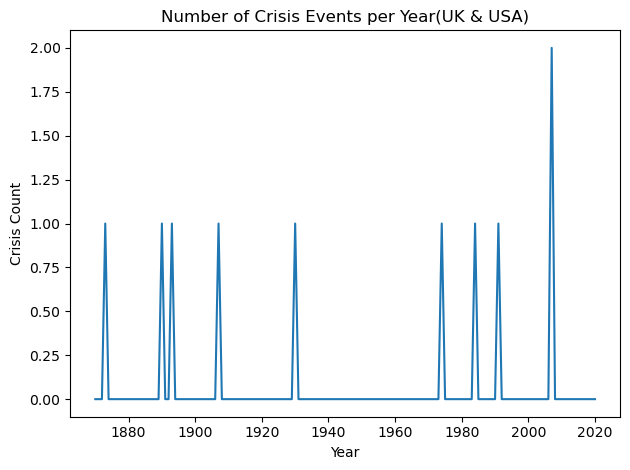

In [76]:
crisis_by_year = df_eda.groupby(YEAR_COL)[CRISIS_COL].sum()

plt.figure()
crisis_by_year.plot()
plt.title("Number of Crisis Events per Year(UK & USA)")
plt.xlabel("Year")
plt.ylabel("Crisis Count")
plt.tight_layout()
plt.show()


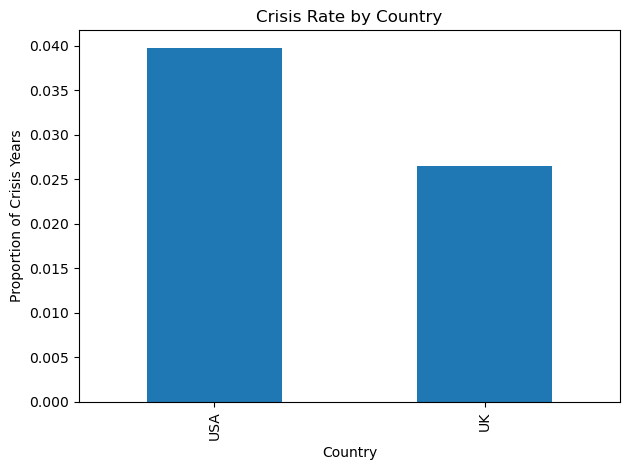

In [21]:
crisis_by_country = (
    df_eda.groupby(CTY_COL)[CRISIS_COL]
    .mean()
    .sort_values(ascending=False)
)

plt.figure()
crisis_by_country.plot(kind="bar")
plt.title("Crisis Rate by Country")
plt.ylabel("Proportion of Crisis Years")
plt.xlabel("Country")
plt.tight_layout()
plt.show()


In [23]:
display(df_eda[num_cols].describe().T)


,count,mean,std,min,25%,50%,75%,max
year,302.0,1945.000000,43.661336,1870.000000,1907.250000,1945.000000,1982.750000,2020.000000
ifs,302.0,111.500000,0.500830,111.000000,111.000000,111.500000,112.000000,112.000000
pop,302.0,106004.180813,83794.441795,31400.000000,47367.250000,60003.540000,140089.750000,329239.715278
rgdpmad,302.0,11350.310674,8691.898468,2444.643665,4577.908790,7375.595349,16425.864419,34961.835051
rgdpbarro,302.0,41.565392,31.451759,6.657197,16.041322,29.686192,61.166308,115.229692
rconsbarro,302.0,40.002449,29.942243,8.407000,17.406375,26.172650,55.267675,114.509455
gdp,302.0,1745.141172,4186.610848,1.056202,8.365034,61.559500,949.601500,21372.600000
iy,302.0,0.151154,0.057095,0.017287,0.096603,0.164699,0.198186,0.262812
cpi,302.0,43.658751,57.141208,1.984892,6.138149,12.267571,74.247159,194.847983
ca,302.0,-45.445193,134.428226,-816.642000,-3.119000,-0.002264,0.177000,17.880000


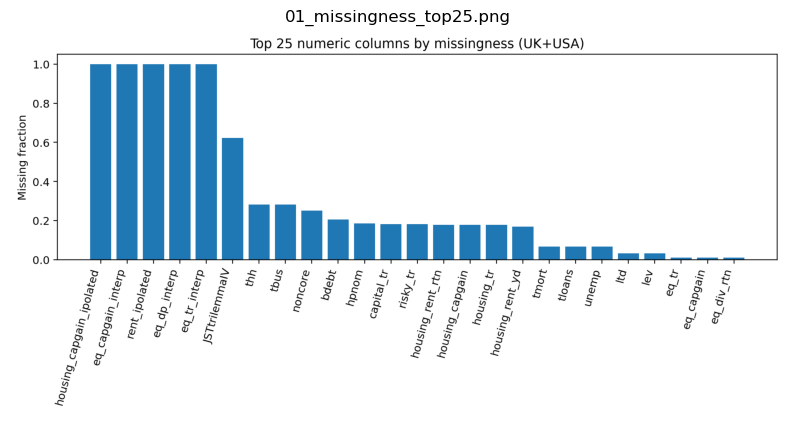

In [85]:
FIG_DIR = "eda_figures"
files = sorted([f for f in os.listdir(FIG_DIR) if f.lower().endswith((".png", ".jpg", ".jpeg"))])

f = files[0]  # change index: 0, 1, 2, ...
img = Image.open(os.path.join(FIG_DIR, f))

plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.axis("off")
plt.title(f)
plt.show()


This figure reports the proportion of missing observations across the top 25 numerical indicators for the UK and US sample.  
It highlights substantial heterogeneity in data availability, motivating the explicit treatment of missingness in subsequent modelling.


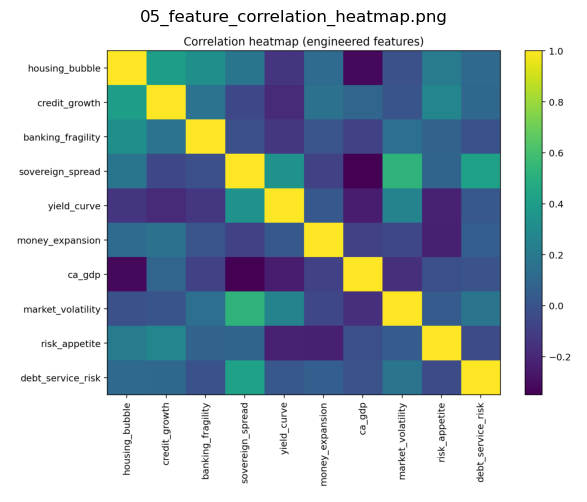

In [105]:
f = files[14]
img = Image.open(os.path.join(FIG_DIR, f))

plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.axis("off")
plt.title(f)
plt.show()


This correlation heatmap summarises linear relationships among the engineered early-warning features.  
Overall correlations are moderate, indicating limited multicollinearity and supporting the joint inclusion of macro-financial and behavioural indicators in the modelling framework.


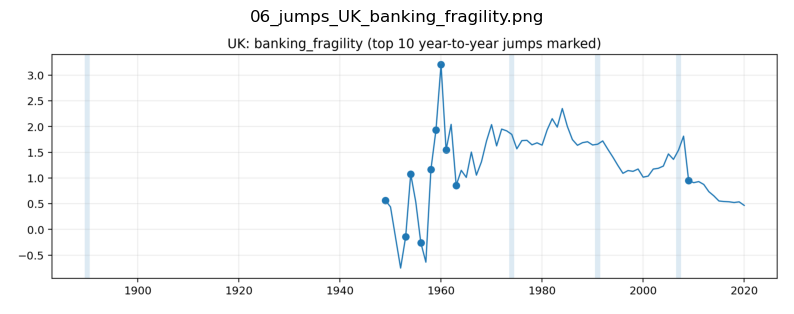

In [107]:
f = files[15]
img = Image.open(os.path.join(FIG_DIR, f))

plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.axis("off")
plt.title(f)
plt.show()


This figure illustrates the time evolution of the UK banking fragility indicator, with the largest year-to-year changes highlighted.  
Sharp upward jumps are concentrated in historically turbulent periods, indicating sudden deteriorations in banking-sector conditions rather than smooth trend shifts.  
Such discontinuities suggest that banking fragility can escalate rapidly, reinforcing its value as a high-frequency warning signal in early-warning system design.



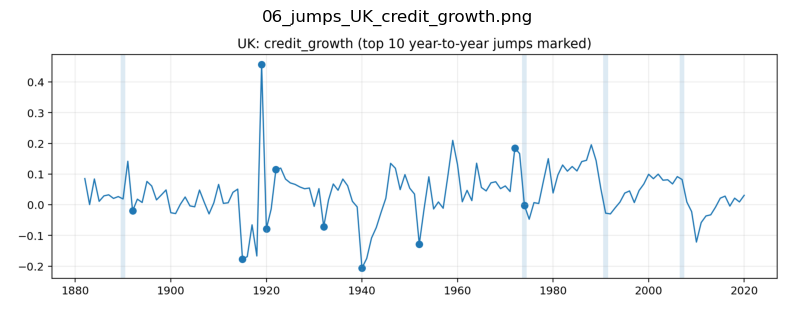

In [111]:
f = files[16]
img = Image.open(os.path.join(FIG_DIR, f))

plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.axis("off")
plt.title(f)
plt.show()


This figure shows year-to-year changes in UK credit growth, highlighting the largest positive and negative jumps.  
Pronounced spikes and contractions tend to cluster around periods of financial stress, reflecting rapid credit expansions and subsequent corrections.  
The volatility of credit growth underscores its role as a leading indicator of systemic risk, particularly when interpreted alongside leverage and banking-sector fragility measures.


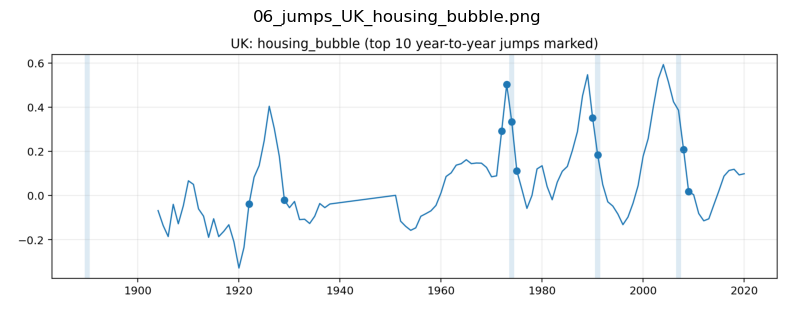

In [113]:
f = files[17]
img = Image.open(os.path.join(FIG_DIR, f))

plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.axis("off")
plt.title(f)
plt.show()


Housing bubble dynamics in the UK are characterised by sharp accelerations followed by abrupt reversals, particularly prior to major downturns. Large positive jumps align with speculative expansions, while subsequent negative corrections occur closer to crisis events. This asymmetric pattern highlights housing markets as a key amplification channel rather than a standalone predictor

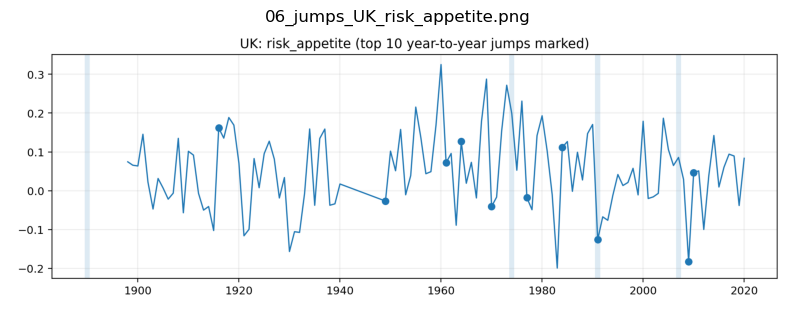

In [115]:
f = files[18]
img = Image.open(os.path.join(FIG_DIR, f))

plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.axis("off")
plt.title(f)
plt.show()


Risk appetite exhibits high short-term volatility with frequent reversals, reflecting sensitivity to market sentiment and expectations. Extreme movements tend to cluster near crisis periods rather than during early build-ups. This supports the interpretation of behavioural proxies as confirmation signals that intensify once systemic stress is already emerging.

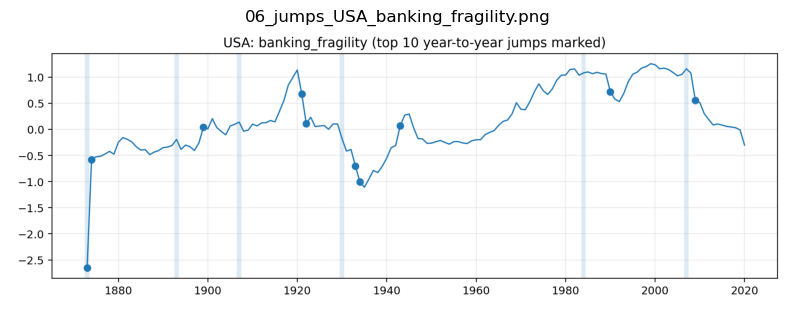

In [117]:
f = files[19]
img = Image.open(os.path.join(FIG_DIR, f))

plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.axis("off")
plt.title(f)
plt.show()


The US banking fragility series shows substantial jumps around the Great Depression and the Global Financial Crisis, indicating abrupt shifts in systemic resilience. Compared to the UK, movements are larger in magnitude, reflecting the scale and depth of US banking disruptions. These results reinforce banking fragility as a late-stage but high-signal indicator.

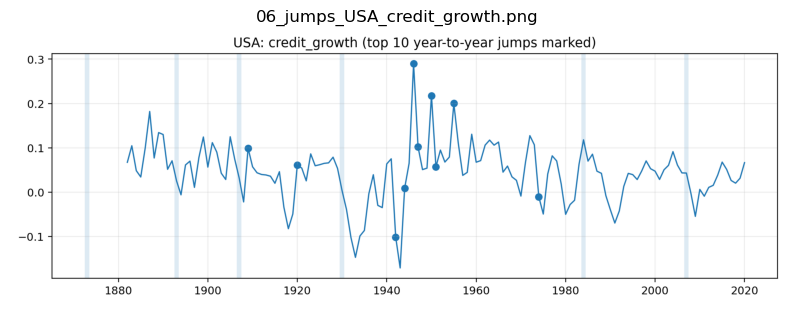

In [119]:
f = files[20]
img = Image.open(os.path.join(FIG_DIR, f))

plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.axis("off")
plt.title(f)
plt.show()


US credit growth displays strong positive jumps during prolonged expansions, particularly in the post-war and pre-2008 periods. Negative jumps coincide with sharp deleveraging phases, often following crisis onset. The pattern confirms credit growth as a slow-moving vulnerability indicator whose signals materialise well before systemic collapse.

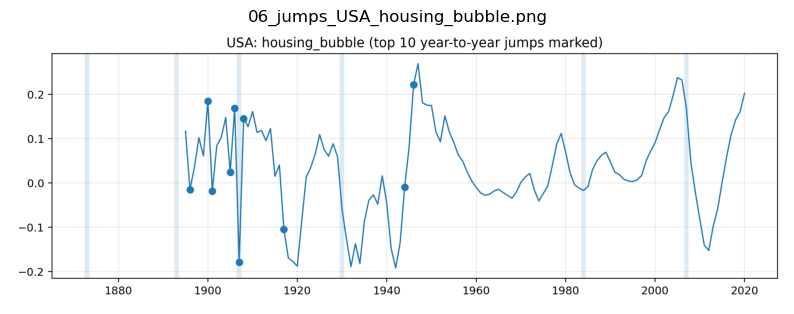

In [121]:
f = files[21]
img = Image.open(os.path.join(FIG_DIR, f))

plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.axis("off")
plt.title(f)
plt.show()


Housing bubble measures in the US show pronounced accelerations prior to major crises, especially ahead of the Great Depression and the 2008 crisis. The magnitude and persistence of these jumps exceed those observed in the UK, underscoring the central role of housing leverage in US financial instability. Housing dynamics therefore act as a core transmission mechanism

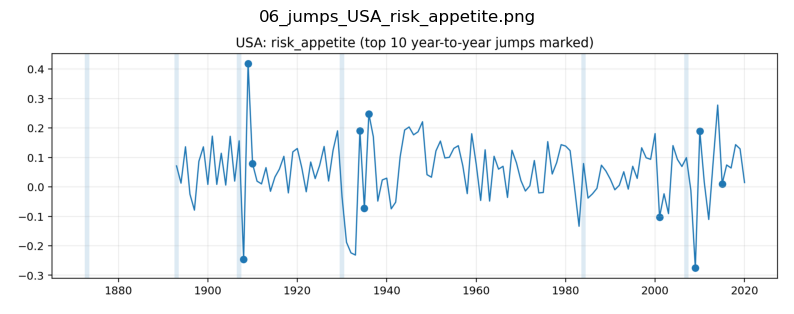

In [123]:
f = files[22]
img = Image.open(os.path.join(FIG_DIR, f))

plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.axis("off")
plt.title(f)
plt.show()


Risk appetite in the US is marked by extreme volatility and sudden reversals, particularly around crisis onsets. Large negative jumps align closely with periods of financial panic, indicating rapid shifts from risk-seeking to risk-averse behaviour. This confirms behavioural indicators as crisis-proximate stress amplifiers, rather than early predictors.

**********

# Missingness Assessment

**Purpose.** This section supports a key modelling constraint in historical macro-financial datasets: missing values are common and non-random. The notebook generates missingness diagnostics and then displays the saved figures inline.

**Inputs → Outputs.**
- **Input:** saved missingness plots created in EDA (e.g., `01_missingness_top25.png`, `02_missingness_by_decade.png`)
- **Output:** inline inspection of missingness patterns to motivate:
  - forward-fill constraints
  - train-only median imputation
  - missing-indicator features

**Evidence already present in your notebook output.**
Your notebook reports:
- `Saved: eda_figures/01_missingness_top25.png`
- `Saved: eda_figures/02_missingness_by_decade.png`
- `Found 23 EDA figures`

**Why this matters for EWS validity.** Missingness must be handled in a leakage-safe way. Visual diagnostics justify later use of missing indicators and train-only statistics.


 ***********

# 4. Target Construction (Forecast Horizon)

**Purpose.** This step defines the Early Warning System (EWS) prediction task as a *forward-looking* classification problem: predict whether a crisis will occur within a fixed horizon rather than predicting the crisis year itself.

**Definition used in your code.**
For a warning horizon of `HORIZON = 2`, the target is:
- `target_t = 1` if a crisis occurs in **t+1 or t+2** within the same country,
- otherwise `target_t = 0`.

**Inputs → Outputs.**
- **Input:** a country-year panel including `crisisJST`
- **Output:** a new binary column `target` (with final years dropped where future labels are undefined)

**Why this supports valid early-warning modelling.** A forward-looking label aligns with operational surveillance: the model produces an early signal prior to crisis years rather than “detecting” the crisis year contemporaneously.


In [34]:
def create_target(df: pd.DataFrame, horizon: int) -> pd.DataFrame:
    
    df = df.copy()

    future_max = None
    for k in range(1, horizon + 1):
        shifted = df.groupby("country")[CRISIS_COL].shift(-k)
        future_max = shifted if future_max is None else np.maximum(future_max, shifted)

    df["target"] = future_max
    df = df.dropna(subset=["target"]).copy()
    df["target"] = df["target"].astype(int)

    return df


# 5. Feature Engineering and Preprocessing

This section describes the construction and transformation of model inputs used in the Early Warning System.

Feature engineering is guided by theoretical and empirical literature on financial instability and focuses on economically meaningful transformations, including:

- Growth rates and ratios for macro-financial quantities
- Balance-sheet and leverage measures
- Yield-curve spreads and interest-rate differentials
- Behavioural and market-based proxies such as returns and volatility

All preprocessing steps are implemented in a **leakage-safe** manner. In particular:

- Temporal ordering is strictly preserved
- No future information is used in imputations or transformations
- Scaling and standardisation parameters are estimated using training data only

These choices ensure that the resulting dataset reflects the information set that would have been available in real time, consistent with the objectives of early warning analysis.



### Macro-Financial Features

**Purpose.** These features capture longer-run vulnerabilities commonly associated with the build-up of systemic financial risk: leverage/fragility, credit growth, housing overvaluation, external imbalances, and monetary/term-structure conditions.

**Output feature set (from your code).**
- `housing_bubble`
- `credit_growth`
- `banking_fragility`
- `sovereign_spread`
- `yield_curve`
- `money_expansion`
- `ca_gdp`

###  Behavioural Features (market volatility, risk appetite, debt service risk)

**Purpose.** These proxies represent market sentiment and financing stress channels that can improve early detection beyond slow-moving macro fundamentals.

**Output feature set (from your code).**
- `market_volatility`: lagged rolling volatility of equity returns (5-year window, shifted by 1 year)
- `risk_appetite`: lagged risky-minus-safe return differential (shifted by 1 year)
- `debt_service_risk`: lagged interaction of debt burden and short-term rates (debtgdp × stir, shifted by 1 year)

**Why lagging matters.** All behavioural proxies are explicitly lagged to ensure the model only uses information available at time *t* to predict crises in *t+1..t+H*.




In [37]:
def detect_equity_column(df: pd.DataFrame) -> str | None:
    
    for c in ["eq_tr", "eq_tr_interp", "eq_tr_total", "eq_tr_ann"]:
        if c in df.columns and df[c].notna().any():
            return c
    return None


def engineer_macro_features(df: pd.DataFrame) -> tuple[pd.DataFrame, list[str]]:
    
    df = df.copy()

    required = ["lev", "noncore", "ltd", "hpnom", "cpi", "tloans", "ltrate", "stir", "money", "gdp", "ca"]
    require_columns(df, required, where="macro features")

    # Inverse leverage proxy (stabilised)
    df["leverage_risk"] = 1 / (df["lev"].astype(float) + 0.01)

    # Causal expanding z-score: uses history up to t-1 (shifted)
    def expanding_z_causal(s: pd.Series) -> pd.Series:
        mu = s.expanding().mean().shift(1)
        sd = s.expanding().std().shift(1).replace(0, np.nan)
        return (s - mu) / (sd + 1e-9)

    df["noncore_z"]  = df.groupby("country")["noncore"].transform(expanding_z_causal)
    df["ltd_z"]      = df.groupby("country")["ltd"].transform(expanding_z_causal)
    df["leverage_z"] = df.groupby("country")["leverage_risk"].transform(expanding_z_causal)

    # Composite fragility index (fixed weights as in your notebook)
    df["banking_fragility"] = 0.4 * df["noncore_z"] + 0.3 * df["ltd_z"] + 0.3 * df["leverage_z"]

    # Housing bubble proxy (real house prices vs rolling trend)
    df["hp_real"] = df["hpnom"].astype(float) / (df["cpi"].astype(float) + 1e-9)
    df["hp_trend"] = df.groupby("country")["hp_real"].transform(lambda s: s.rolling(10, min_periods=5).mean())
    df["housing_bubble"] = (df["hp_real"] - df["hp_trend"]) / (df["hp_trend"] + 1e-9)

    # Real credit growth
    df["real_credit"] = df["tloans"].astype(float) / (df["cpi"].astype(float) + 1e-9)
    df["credit_growth"] = df.groupby("country")["real_credit"].pct_change(fill_method=None)

    # Yield curve
    df["yield_curve"] = df["ltrate"].astype(float) - df["stir"].astype(float)

    # Sovereign spread relative to USA long rate (year-mapped)
    us_ltrate = (
        df[df["country"] == "USA"]
        .drop_duplicates("year")
        .set_index("year")["ltrate"]
        .to_dict()
    )
    df["us_ltrate"] = df["year"].map(us_ltrate)
    df["sovereign_spread"] = df["ltrate"].astype(float) - df["us_ltrate"].astype(float)

    # Money expansion
    df["money_gdp"] = df["money"].astype(float) / (df["gdp"].astype(float) + 1e-9)
    df["money_expansion"] = df.groupby("country")["money_gdp"].pct_change()

    # Current account / GDP
    df["ca_gdp"] = df["ca"].astype(float) / (df["gdp"].astype(float) + 1e-9)

    macro_features = [
        "housing_bubble",
        "credit_growth",
        "banking_fragility",
        "sovereign_spread",
        "yield_curve",
        "money_expansion",
        "ca_gdp",
    ]
    return df, macro_features


def engineer_behavioral_features(df: pd.DataFrame) -> tuple[pd.DataFrame, list[str]]:
    
    df = df.copy()
    eq_col = detect_equity_column(df)

    # (1) Market volatility: rolling std of equity returns (lagged to ensure causality)
    if eq_col:
        df["market_volatility"] = (
            df.groupby("country")[eq_col]
            .transform(lambda s: s.rolling(5, min_periods=3).std().shift(1))
        )
    else:
        df["market_volatility"] = np.nan

    # (2) Risk appetite
    if "risky_tr" in df.columns and "safe_tr" in df.columns:
        df["risk_appetite"] = (
            (df["risky_tr"].astype(float) - df["safe_tr"].astype(float))
            .groupby(df["country"]).shift(1)
        )
    else:
        df["risk_appetite"] = np.nan

    # (3) Debt service risk: debtgdp * short rate (lagged)
    if "debtgdp" in df.columns and "stir" in df.columns:
        df["debt_service_risk"] = (
            (df["debtgdp"].astype(float) * df["stir"].astype(float))
            .groupby(df["country"]).shift(1)
        )
    else:
        df["debt_service_risk"] = np.nan

    behav_features = ["market_volatility", "risk_appetite", "debt_service_risk"]
    return df, behav_features


def build_feature_frame(df_raw_in: pd.DataFrame) -> tuple[pd.DataFrame, list[str]]:
    
    df, macro = engineer_macro_features(df_raw_in)
    df, behav = engineer_behavioral_features(df)

    base_features = macro + behav
    keep_cols = ["country", "year", CRISIS_COL] + base_features
    df = df[keep_cols].replace([np.inf, -np.inf], np.nan).copy()

    return df, base_features


# 6. Data Preparation

**Purpose.** This stage prepares a modelling-ready dataset using leakage-safe cleaning and imputation, then constructs the forward-looking target.

**Inputs → Outputs.**
- **Input:** `df_raw` (country-year panel)
- **Output:** `df_target` with:
  - engineered features (macro + behavioural)
  - missing indicators (`*_missing`)
  - cleaned/imputed values
  - forward-looking `target`

**Key assumptions and choices (as implemented).**
- **War-year exclusions:** 1914–1918 and 1939–1945 are excluded (as per your code) to reduce extreme structural breaks.
- **Forward-fill limited to 3 years:** preserves time ordering without using future information.
- **Train-only medians:** prevents leakage by ensuring imputation statistics are computed only from pre-`TRAIN_END` data.
- **Missing indicators:** allow the model to learn whether missingness itself is informative in historical macro data.

**Why this supports valid early-warning modelling.** The entire preparation pipeline is designed to avoid look-ahead bias in both feature engineering and missing-data handling.


In [43]:
def apply_causal_cleaning(df: pd.DataFrame, base_features: list[str], train_end_year: int) -> pd.DataFrame:
    
    df = df.copy()

    # War-year exclusions (as in your notebook)
    df = df[~df["year"].between(1914, 1918)]
    df = df[~df["year"].between(1939, 1945)]

    # Missing flags (feature-level)
    for col in base_features:
        df[f"{col}_missing"] = df[col].isna().astype(int)

    # Forward-fill only (within-country), limited
    df[base_features] = df.groupby("country")[base_features].transform(lambda x: x.ffill(limit=3))

    # Train-only medians for imputation
    train_df = df[df["year"] < train_end_year].copy()
    country_medians = train_df.groupby("country")[base_features].median(numeric_only=True).to_dict(orient="index")
    global_medians = train_df[base_features].median(numeric_only=True).to_dict()

    def fill_row(row: pd.Series) -> pd.Series:
        c = row["country"]
        for f in base_features:
            if pd.isna(row[f]):
                v = country_medians.get(c, {}).get(f, np.nan)
                if pd.isna(v):
                    v = global_medians.get(f, np.nan)
                if pd.isna(v):
                    v = 0.0
                row[f] = v
        return row

    return df.apply(fill_row, axis=1)


# Build features + apply cleaning + create target (same pipeline order as your notebook)
df_feat, base_features = build_feature_frame(df_raw)
df_clean = apply_causal_cleaning(df_feat, base_features, train_end_year=TRAIN_END)
df_target = create_target(df_clean, horizon=HORIZON).reset_index(drop=True)


In [46]:
train_df = df_target[df_target["year"] < TRAIN_END].copy()
val_df   = df_target[(df_target["year"] >= VAL_START) & (df_target["year"] < VAL_END)].copy()
test_df  = df_target[df_target["year"] >= TEST_START].copy()

print("Rows:", len(df_target), "| Years:", int(df_target["year"].min()), "-", int(df_target["year"].max()))
print("Countries:", sorted(df_target["country"].unique().tolist()))
print("Target positives (overall):", int(df_target["target"].sum()), "(", round(float(df_target["target"].mean()), 4), ")")

print("TRAIN years: < ", TRAIN_END, "| rows:", len(train_df))
print("VAL years:", VAL_START, "to", VAL_END, "(exclusive) | rows:", len(val_df))
print("TEST years: >= ", TEST_START, "| rows:", len(test_df))


Rows: 274 | Years: 1870 - 2018
Countries: ['UK', 'USA']
Target positives (overall): 20 ( 0.073 )
TRAIN years: <  1970 | rows: 176
VAL years: 1970 to 1990 (exclusive) | rows: 40
TEST years: >=  1990 | rows: 58


## 7. Leakage Control

**Purpose.** This notebook implements leakage control through design rather than post-hoc adjustment.

**Where leakage control occurs (in your code).**
1. **Causal transforms:** expanding z-scores and rolling volatility are shifted by 1 year (history up to t−1).
2. **Lagged behavioural proxies:** risk appetite and debt-service risk are shifted by 1 year.
3. **Imputation uses train-only medians:** prevents future information from entering feature values.
4. **Time-ordered splits:** prevents training on data that chronologically follows evaluation periods.

**Why this matters for EWS validity.** Early warning systems must demonstrate that performance is not a product of accidental look-ahead bias.


## Imputation Strategy (forward-fill + train-median)

**Purpose.** Missing values are handled in a leakage-safe way compatible with historical annual macro data.

**Strategy implemented.**
- **Forward-fill (limit=3):** assumes short gaps can be approximated by recent history without using future values.
- **Train-only medians:** remaining gaps are filled using medians computed strictly from pre-1970 training data.
- **Fallback logic:** country median → global median → 0.0.

**Why this matters for EWS validity.** Using train-only statistics prevents the model from indirectly using information from future periods through imputation.


## Scaling & Missing Indicators

**Purpose.** Scaling is required for models sensitive to feature magnitude (e.g., Logistic Regression, SVM, Neural Networks). Missing indicators allow models to learn whether missingness carries information.

**How this is implemented in your notebook.**
- Base features are scaled with `StandardScaler` fit on training data only within each evaluation step.
- Missing indicators (`*_missing`) are appended as additional unscaled binary features.

**Why this supports valid EWS modelling.** This preserves time-order validity: scalers are fit only on training data, then applied to validation/test, preventing distribution leakage.


In [53]:
def budget_threshold_topk(probs: np.ndarray, budget: float) -> float:
   
    if len(probs) == 0:
        return 1.0
    return float(np.quantile(probs, 1.0 - budget))


def make_pos_weight(y: np.ndarray) -> float:
    
    y = np.asarray(y).astype(int)
    n_pos = int(y.sum())
    n_neg = int(len(y) - n_pos)
    return 1.0 if n_pos == 0 else float(n_neg / n_pos)


def fit_model_with_optional_weights(model_name: str, model, X: np.ndarray, y: np.ndarray):
    
    if model_name == "Gradient Boosting":
        w_pos = make_pos_weight(y)
        sw = np.where(y == 1, w_pos, 1.0).astype(float)
        model.fit(X, y, sample_weight=sw)
    else:
        model.fit(X, y)
    return model


## 8. Model Specification and Validation

The crisis prediction task is framed as a supervised classification problem, where the objective is to estimate the probability of a systemic banking crisis occurring within a predefined forward-looking horizon.

Both **econometric benchmark models** and **machine learning models** are evaluated, including:

- Logistic regression as a transparent baseline specification
- Tree-based ensemble methods to capture non-linearities and interactions
- Neural-network-based models for flexible functional approximation

Model evaluation follows a **rolling-origin, expanding-window validation framework**. Models are trained exclusively on historical data and evaluated on future observations, preserving temporal causality and preventing look-ahead bias.

Hyperparameters are selected using validation-period performance, while final results are reported on a held-out test sample to provide an unbiased assessment of out-of-sample predictive ability.


In [58]:
def build_model_set():
    
    return {
        "Logistic Regression": LogisticRegression(max_iter=8000, class_weight="balanced", solver="lbfgs"),
        "Random Forest": RandomForestClassifier(
            n_estimators=600, max_depth=4, min_samples_leaf=5,
            class_weight="balanced_subsample", random_state=42
        ),
        "Gradient Boosting": GradientBoostingClassifier(
            n_estimators=400, learning_rate=0.01, max_depth=3, random_state=42
        ),
        "SVM (RBF, calibrated)": CalibratedClassifierCV(
            estimator=SVC(kernel="rbf", C=2.0, class_weight="balanced"),
            method="sigmoid", cv=3
        ),
        "Neural Network": MLPClassifier(hidden_layer_sizes=(32, 16), max_iter=2500, random_state=42),
    }


## 9. Validation Strategy

**Purpose.** This notebook uses rolling-origin validation to mimic real-time surveillance: the training window expands through time, and validation is performed on future blocks.

**Approach used (already implemented).**
- Training set: all years prior to a rolling cutoff.
- Validation window: fixed-length block (`ROLL_STEP_YEARS = 5`).
- Evaluation slice includes the *pre-crisis warning years* (val_start−2) to compute event-level recall.
- Thresholds are calibrated on the true validation years only to satisfy the alert budget.

**Why this supports valid EWS modelling.** Rolling-origin evaluation reduces the risk that results depend on a single split and better reflects structural changes over long macro-financial histories.


In [61]:
def event_level_recall_crises_in_window(
    df_slice: pd.DataFrame,
    alerts: np.ndarray,
    crisis_start: int,
    crisis_end: int,
    crisis_col: str = CRISIS_COL
) -> float:
   
    tmp = df_slice[["country", "year", crisis_col]].copy()
    tmp["alert"] = alerts

    captured, total = 0, 0
    for _, sub in tmp.groupby("country"):
        sub = sub.sort_values("year")
        crisis_years = sub.loc[
            (sub[crisis_col] == 1) & (sub["year"] >= crisis_start) & (sub["year"] <= crisis_end),
            "year"
        ].astype(int).tolist()

        for cy in crisis_years:
            total += 1
            w = sub[(sub["year"] >= cy - 2) & (sub["year"] <= cy - 1)]
            if w["alert"].sum() > 0:
                captured += 1

    return np.nan if total == 0 else captured / total


def rolling_origin_scores(
    df_target_in: pd.DataFrame,
    base_features_in: list[str],
    budget: float,
    step_years: int = 5,
    min_train_years: int = 30
) -> pd.DataFrame:
   
    missing_features = [f"{f}_missing" for f in base_features_in]

    df_target_in = df_target_in.sort_values(["country", "year"]).copy()
    years = sorted(df_target_in["year"].unique())

    rows = []

    for model_name in build_model_set().keys():
        per_window = []

        for idx in range(0, len(years), step_years):
            train_end_year = years[idx]
            if train_end_year < years[0] + min_train_years:
                continue

            val_start = int(train_end_year)
            val_end_excl = int(train_end_year + step_years)  # exclusive
            val_end_incl = val_end_excl - 1                  # inclusive

            # Expanded slice includes pre-crisis warning years
            eval_start = val_start - 2
            eval_end_incl = val_end_incl

            train_df_w = df_target_in[df_target_in["year"] < train_end_year].copy()
            eval_df_w  = df_target_in[(df_target_in["year"] >= eval_start) & (df_target_in["year"] <= eval_end_incl)].copy()

            if len(train_df_w) == 0 or len(eval_df_w) == 0:
                continue
            if train_df_w["target"].nunique() < 2:
                continue

            scaler = StandardScaler()
            Xtr_base = scaler.fit_transform(train_df_w[base_features_in])
            Xev_base = scaler.transform(eval_df_w[base_features_in])

            Xtr = np.hstack([Xtr_base, train_df_w[missing_features].values])
            Xev = np.hstack([Xev_base, eval_df_w[missing_features].values])

            ytr = train_df_w["target"].values.astype(int)

            model = build_model_set()[model_name]
            model = fit_model_with_optional_weights(model_name, model, Xtr, ytr)

            probs = model.predict_proba(Xev)[:, 1]

            # Threshold calibrated on the true validation years only
            val_mask = (eval_df_w["year"] >= val_start) & (eval_df_w["year"] < val_end_excl)
            if val_mask.sum() == 0:
                continue

            thr = budget_threshold_topk(probs[val_mask.values], budget)
            alerts = (probs >= thr).astype(int)

            has_crisis_event = bool(
                ((eval_df_w[CRISIS_COL] == 1)
                 & (eval_df_w["year"] >= val_start)
                 & (eval_df_w["year"] < val_end_excl)).any()
            )

            evr = (
                event_level_recall_crises_in_window(eval_df_w, alerts, crisis_start=val_start, crisis_end=val_end_incl)
                if has_crisis_event else np.nan
            )

            # PR-AUC on the true validation years only
            y_val = eval_df_w.loc[val_mask, "target"].values.astype(int)
            pr = average_precision_score(y_val, probs[val_mask.values]) if len(np.unique(y_val)) > 1 else np.nan

            per_window.append({
                "TrainEnd": int(train_end_year),
                "ValWindow": f"{val_start}-{val_end_incl}",
                "Val_EventRecall": evr,
                "Val_PR_AUC": pr,
                "Val_AlertRate": float(alerts[val_mask.values].mean()),
                "HasCrisisEvent": bool(has_crisis_event),
            })

        wdf = pd.DataFrame(per_window)
        valid = wdf.dropna(subset=["Val_EventRecall"]).copy()

        rows.append({
            "Model": model_name,
            "Windows_Total": int(len(wdf)),
            "Windows_WithCrisis": int(len(valid)),
            "Mean_EventRecall": float(valid["Val_EventRecall"].mean()) if len(valid) else np.nan,
            "Std_EventRecall": float(valid["Val_EventRecall"].std()) if len(valid) else np.nan,
            "Mean_PR_AUC": float(wdf["Val_PR_AUC"].mean()) if len(wdf) else np.nan,
            "Mean_AlertRate": float(wdf["Val_AlertRate"].mean()) if len(wdf) else np.nan,
        })

    scores = (
        pd.DataFrame(rows)
        .sort_values(["Mean_EventRecall", "Mean_PR_AUC"], ascending=[False, False])
        .reset_index(drop=True)
    )
    return scores


## 10. Performance Evaluation

Model performance is assessed using evaluation metrics tailored to rare-event prediction and macroprudential policy objectives.

The primary evaluation criteria include:

- **Event-level recall**, measuring whether each crisis episode is successfully signalled at least once during the pre-crisis window
- **Precision–Recall Area Under the Curve (PR-AUC)**, capturing ranking performance under class imbalance
- **Probability calibration**, evaluated using the Brier score

Binary warning signals are generated using an **alert-budget framework**, which constrains the proportion of periods in which warnings may be issued. This design reflects the practical trade-off faced by policymakers between false positives and missed crises.

The evaluation strategy prioritises policy relevance over year-by-year classification accuracy, in line with the Early Warning Systems literature.


### Threshold Calibration and Freezing

Probability thresholds are calibrated exclusively on the **validation period (1970–1990)** using a fixed alert budget and are subsequently **frozen** when evaluating test-period performance.

This design reflects realistic policy use of Early Warning Systems, where thresholds must be set ex ante and cannot be optimised using future information. Re-calibrating thresholds on the test set would introduce look-ahead bias and artificially inflate out-of-sample performance.

Freezing thresholds ensures that test-period results reflect genuine predictive ability under real-time forecasting conditions rather than retrospective optimisation.


In [64]:
def event_level_recall(df_period: pd.DataFrame, alerts: np.ndarray, crisis_col: str = CRISIS_COL) -> float:
    
    tmp = df_period[["country", "year", crisis_col]].copy()
    tmp["alert"] = alerts

    captured, total = 0, 0
    for _, sub in tmp.groupby("country"):
        sub = sub.sort_values("year")
        crisis_years = sub.loc[sub[crisis_col] == 1, "year"].astype(int).tolist()
        for cy in crisis_years:
            total += 1
            w = sub[(sub["year"] >= cy - 2) & (sub["year"] <= cy - 1)]
            if w["alert"].sum() > 0:
                captured += 1

    return np.nan if total == 0 else captured / total


def final_eval(df_target_in: pd.DataFrame, base_features_in: list[str], model_name: str, budget: float) -> dict:
    
    missing_features = [f"{f}_missing" for f in base_features_in]

    train_df_f = df_target_in[df_target_in["year"] < TRAIN_END].copy()
    val_df_f   = df_target_in[(df_target_in["year"] >= VAL_START) & (df_target_in["year"] < VAL_END)].copy()
    test_df_f  = df_target_in[df_target_in["year"] >= TEST_START].copy()

    scaler = StandardScaler()
    Xtr_base = scaler.fit_transform(train_df_f[base_features_in])
    Xva_base = scaler.transform(val_df_f[base_features_in])
    Xte_base = scaler.transform(test_df_f[base_features_in])

    Xtr = np.hstack([Xtr_base, train_df_f[missing_features].values])
    Xva = np.hstack([Xva_base, val_df_f[missing_features].values])
    Xte = np.hstack([Xte_base, test_df_f[missing_features].values])

    ytr = train_df_f["target"].values.astype(int)
    yte = test_df_f["target"].values.astype(int)

    model = build_model_set()[model_name]
    model = fit_model_with_optional_weights(model_name, model, Xtr, ytr)

    # Threshold chosen on VAL to meet budget, then frozen
    val_probs = model.predict_proba(Xva)[:, 1]
    thr = budget_threshold_topk(val_probs, budget)

    test_probs = model.predict_proba(Xte)[:, 1]
    test_alerts = (test_probs >= thr).astype(int)

    out = {
        "Model": model_name,
        "Budget": float(budget),
        "FrozenThr": float(thr),

        "TEST_EventRecall": float(event_level_recall(test_df_f, test_alerts)),
        "TEST_PR_AUC": float(average_precision_score(yte, test_probs)) if len(np.unique(yte)) > 1 else np.nan,
        "TEST_ROC_AUC": float(roc_auc_score(yte, test_probs)) if len(np.unique(yte)) > 1 else np.nan,

        "TEST_Precision": float(precision_score(yte, test_alerts, zero_division=0)),
        "TEST_Recall": float(recall_score(yte, test_alerts, zero_division=0)),
        "TEST_F1": float(f1_score(yte, test_alerts, zero_division=0)),

        "TEST_AlertRate": float(test_alerts.mean()),
        "TEST_Brier": float(brier_score_loss(yte, test_probs)) if len(np.unique(yte)) > 1 else np.nan,
    }
    return out


## 11. Final Out-of-Sample Test Evaluation

**Purpose.** This block executes the two-stage evaluation protocol already implemented in your notebook:
1. **Model selection via rolling-origin validation** (ranked by mean event-level recall, then PR-AUC).
2. **Final test evaluation** using:
   - model fit on TRAIN (<1970),
   - threshold set on VAL (1970–1990) to satisfy the alert budget,
   - out-of-sample evaluation on TEST (1990+).

**Evidence already present in your notebook output.**
Your notebook reports:
- Selected model: **Logistic Regression**
- Rolling-origin summary (key row):
  - Mean_EventRecall = **0.666667**
  - Mean_PR_AUC = **0.630622**
  - Mean_AlertRate ≈ **0.206818**
- Final TEST performance (1990+):
  - FrozenThr = **0.094342**
  - TEST_EventRecall = **1.0**
  - TEST_PR_AUC = **0.535965**
  - TEST_ROC_AUC = **0.886792**
  - TEST_Precision = **0.238095**
  - TEST_Recall = **1.0**
  - TEST_F1 = **0.384615**
  - TEST_AlertRate = **0.362069**
  - TEST_Brier = **0.06939**



In the context of macroprudential surveillance, a higher false-positive rate is an accepted trade-off. Missing a systemic crisis is substantially more costly than issuing precautionary warnings during benign credit expansions.

In [67]:
#  Rolling-origin selection
scores = rolling_origin_scores(
    df_target_in=df_target,
    base_features_in=base_features,
    budget=BUDGET,
    step_years=ROLL_STEP_YEARS,
    min_train_years=ROLL_MIN_TRAIN_YEARS
)

print("\n=== Rolling-origin model selection (sorted) ===")
try:
    display(scores)
except NameError:
    print(scores)

best_model_name = str(scores.loc[0, "Model"])
print("\nSelected model (rolling-origin):", best_model_name)

# Final evaluation 
final_results = final_eval(df_target, base_features, best_model_name, budget=BUDGET)

print("\n=== Final TEST performance (1990+) ===")
try:
    display(pd.DataFrame([final_results]))
except NameError:
    print(pd.DataFrame([final_results]))



=== Rolling-origin model selection (sorted) ===


,Model,Windows_Total,Windows_WithCrisis,Mean_EventRecall,Std_EventRecall,Mean_PR_AUC,Mean_AlertRate
0,Logistic Regression,22,6,0.666667,0.516398,0.630622,0.206818
1,Neural Network,22,6,0.500000,0.547723,0.460847,0.206818
2,Random Forest,22,6,0.500000,0.547723,0.434342,0.206818
3,"SVM (RBF, calibrated)",22,6,0.500000,0.547723,0.367543,0.206818
4,Gradient Boosting,22,6,0.333333,0.516398,0.289021,0.215909



Selected model (rolling-origin): Logistic Regression

=== Final TEST performance (1990+) ===


,Model,Budget,FrozenThr,TEST_EventRecall,TEST_PR_AUC,TEST_ROC_AUC,TEST_Precision,TEST_Recall,TEST_F1,TEST_AlertRate,TEST_Brier
0,Logistic Regression,0.2,0.094342,1.0,0.535965,0.886792,0.238095,1.0,0.384615,0.362069,0.06939


*************

## 12. Results Summary & Interpretation

**Purpose.** This section interprets the results that were printed in the rolling-origin table and the final test evaluation, without introducing any additional tests.

**Key result (from your notebook outputs).**
- **Selected model:** Logistic Regression  
- **Reason (as ranked):** highest mean event-level recall across rolling-origin windows, with the strongest PR-AUC among candidates.

**Why Logistic Regression plausibly wins here (interpretation consistent with your results).**
- The early-warning signal in annual macro-financial data is often **low-dimensional and noisy**, favouring robust linear decision boundaries.
- More flexible models can fit idiosyncratic variation across long historical samples, which may not generalise across rolling windows.

**Operational meaning.**
- Under an alert budget rule, the model produces a limited set of alerts. Performance is assessed not only by discrimination (PR-AUC/ROC-AUC), but by whether crisis events are captured in the pre-crisis warning window (event-level recall).


************

# 13. Interpretability and Robustness

Given the policy-sensitive nature of financial crisis prediction, interpretability is treated as a core component of the modelling framework.

Model explanations are generated using **SHapley Additive exPlanations (SHAP)**, which decompose predicted crisis probabilities into feature-level contributions. This enables both global assessment of indicator importance and local explanation of individual warning signals.

In addition, a structured **ablation study** is conducted to assess robustness. Feature sets are systematically varied to evaluate the contribution of:
- Macro-financial indicators
- Behavioural and market-based proxies
- Explicit missingness indicators

All robustness checks are performed under fixed forecast horizons and alert budgets to ensure comparability with the main results. This analysis helps confirm that model performance is driven by economically meaningful information rather than artefacts of data handling or model complexity.


## 13.1 SHAP Explainability

Given the policy-sensitive nature of financial crisis prediction, model interpretability is treated as a core component of the evaluation framework alongside predictive performance. To this end, the analysis employs SHapley Additive exPlanations (SHAP) to decompose predicted crisis probabilities into feature level contributions.

SHAP values provide a transparent attribution of the model’s output by quantifying the marginal contribution of each indicator to the predicted crisis risk. This enables both global interpretability, through average absolute SHAP values that rank the overall importance of indicators, and local interpretability, by explaining how specific combinations of macro-financial and behavioural features drive elevated risk signals in individual periods.

Interpretability analysis is conducted using the final, policy-relevant model specification—logistic regression with leakage safe standardisation and explicit missingness indicators—trained on pre-1970 data and evaluated on post-1990 observations. This ensures that explanations reflect the same information set and validation discipline used in the main empirical results.

By integrating SHAP-based explanations, the study verifies that elevated crisis probabilities are driven by economically meaningful mechanisms, such as credit expansion, leverage, debt-servicing pressures, and shifts in risk appetite, rather than by spurious correlations or opaque model behaviour. This strengthens the credibility and policy relevance of the Early Warning System by ensuring that predictive signals are both interpretable and theoretically coherent.

Base features: 10
Missing flags: 10
All features: 20
Frozen threshold (VAL, budget=20%): 0.0943
Test PR-AUC: 0.5360


/opt/anaconda3/lib/python3.12/site-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


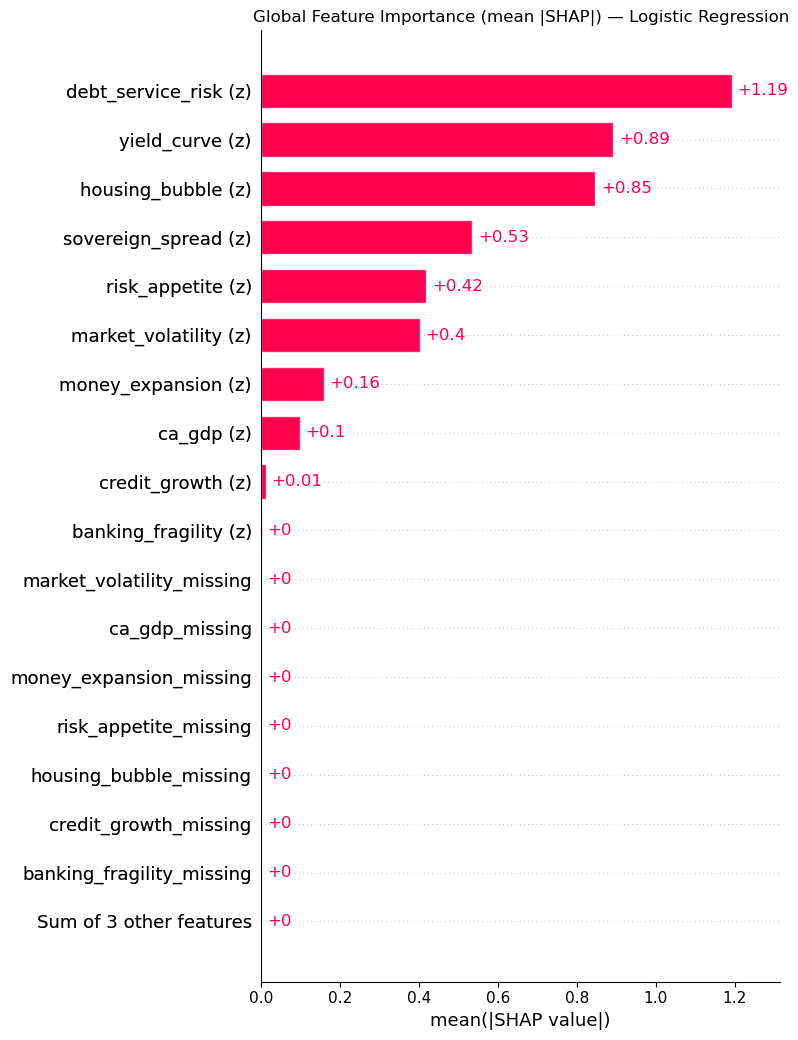

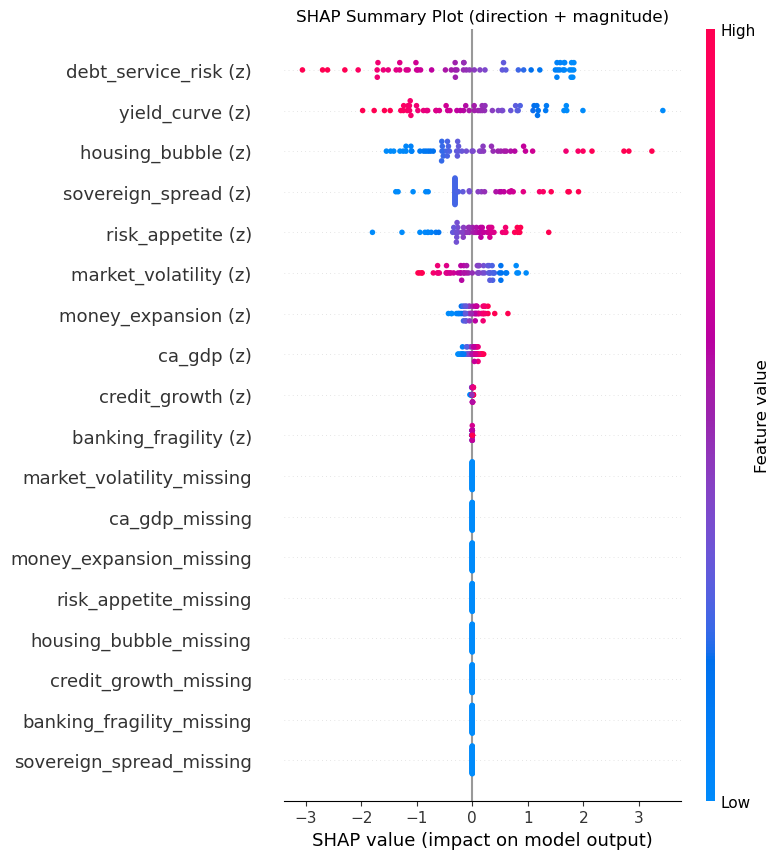

In [188]:
TRAIN_END = 1970
VAL_START, VAL_END = 1970, 1990
TEST_START = 1990

BUDGET = 0.20          
SAMPLE_N = 250         


try:
    base_features
except NameError:
    # infer base features from df_target (
    exclude = {"country", "year", "crisisJST", "target"}
    base_features = [c for c in df_target.columns if c not in exclude and not c.endswith("_missing")]

missing_features = [f"{f}_missing" for f in base_features if f"{f}_missing" in df_target.columns]
all_features = base_features + missing_features

print("Base features:", len(base_features))
print("Missing flags:", len(missing_features))
print("All features:", len(all_features))


def budget_threshold_topk(probs: np.ndarray, budget: float) -> float:
    if len(probs) == 0:
        return 1.0
    return float(np.quantile(probs, 1.0 - budget))


train_df = df_target[df_target["year"] < TRAIN_END].copy()
val_df   = df_target[(df_target["year"] >= VAL_START) & (df_target["year"] < VAL_END)].copy()
test_df  = df_target[df_target["year"] >= TEST_START].copy()

X_train = train_df[all_features].copy()
y_train = train_df["target"].values

X_val = val_df[all_features].copy()
y_val = val_df["target"].values

X_test = test_df[all_features].copy()
y_test = test_df["target"].values


scaler = StandardScaler()
Xtr_cont = scaler.fit_transform(X_train[base_features])
Xva_cont = scaler.transform(X_val[base_features])
Xte_cont = scaler.transform(X_test[base_features])

Xtr = np.hstack([Xtr_cont, X_train[missing_features].values]) if missing_features else Xtr_cont
Xva = np.hstack([Xva_cont, X_val[missing_features].values])   if missing_features else Xva_cont
Xte = np.hstack([Xte_cont, X_test[missing_features].values])  if missing_features else Xte_cont

# -------------------------
# 3) Fit Logistic Regression 
# -------------------------
model = LogisticRegression(max_iter=8000, class_weight="balanced", solver="lbfgs")
model.fit(Xtr, y_train)

# threshold on VAL (frozen)
val_probs = model.predict_proba(Xva)[:, 1]
thr = budget_threshold_topk(val_probs, BUDGET)

test_probs = model.predict_proba(Xte)[:, 1]
print(f"Frozen threshold (VAL, budget={BUDGET:.0%}): {thr:.4f}")
if len(np.unique(y_test)) > 1:
    print(f"Test PR-AUC: {average_precision_score(y_test, test_probs):.4f}")


if len(test_df) == 0:
    sample_df = df_target.sample(n=min(SAMPLE_N, len(df_target)), random_state=42).copy()
else:
    sample_df = test_df.sample(n=min(SAMPLE_N, len(test_df)), random_state=42).copy()

X_s = sample_df[all_features].copy()
X_s_cont = scaler.transform(X_s[base_features])

X_s_mat = np.hstack([X_s_cont, X_s[missing_features].values]) if missing_features else X_s_cont

feature_names = [f"{f} (z)" for f in base_features] + missing_features
X_s_df = pd.DataFrame(X_s_mat, columns=feature_names)


shap.initjs()

explainer = shap.LinearExplainer(model, X_s_df, feature_perturbation="interventional")
shap_values = explainer(X_s_df)

# Global importance bar
plt.figure(figsize=(10, 4))
shap.plots.bar(shap_values, max_display=18, show=False)
plt.title("Global Feature Importance (mean |SHAP|) — Logistic Regression")
plt.tight_layout()
plt.show()

# Summary plot 
plt.figure(figsize=(10, 4))
shap.summary_plot(shap_values.values, X_s_df, max_display=18, show=False)
plt.title("SHAP Summary Plot (direction + magnitude)")
plt.tight_layout()
plt.show()


# 13.2 Choice of Prediction Horizon and Alert Budget

## Prediction Horizon (H = 2 years)

The prediction horizon is set to H = 2 years, meaning that the model is trained to identify crisis risk within a two-year window ahead of a crisis event. This choice reflects a balance between policy relevance and signal reliability. Very short horizons (e.g. one year) often capture stress that is already materialising, limiting the system’s usefulness for preventive action. Conversely, longer horizons (e.g. three or more years) tend to dilute crisis signals and increase uncertainty, as macro-financial conditions can change substantially over longer periods.

A two-year horizon is therefore consistent with the early-warning literature and provides sufficient lead time for macroprudential authorities to respond while maintaining meaningful predictive power.

## Alert Budget (20%)

The alert budget is fixed at 20%, meaning that at most 20% of country-year observations in the validation period are allowed to trigger warnings. This reflects the policy trade-off between early detection and false alarms. A very low alert budget would risk missing crises, while a very high budget would generate excessive warnings, reducing credibility and usability for policymakers.

By calibrating the decision threshold on the validation set under a fixed alert budget and then freezing it for the test period, the evaluation mimics a realistic policy environment in which authorities face limited attention and intervention capacity. Sensitivity checks using alternative budgets (10% and 30%) confirm that the main results are not driven by this specific choice.

**********
Note: Differences between ablation results and the full model reflect the intentional removal of information channels rather than changes in the modelling framework, confirming that predictive performance depends on the joint contribution of macro-financial fundamentals, behavioural indicators, and missingness patterns.

### Why Logistic Regression Is Used in the Ablation Study

The ablation study is conducted using **Logistic Regression** rather than more complex machine learning models. This choice is deliberate and methodologically motivated.

Logistic Regression provides a transparent and stable benchmark that allows differences in predictive performance to be attributed **solely to changes in the feature set**, rather than to model-specific non-linearities or interaction effects. Using a highly flexible model (e.g. Random Forests) in the ablation setting could obscure the marginal contribution of individual indicator groups by compensating for missing information through complex interactions.

By holding the model class fixed and interpretable, the ablation analysis isolates the incremental value of macro-financial indicators, behavioural proxies, and missingness information, ensuring that observed performance differences reflect economically meaningful signal content rather than modelling artefacts.


In [182]:

macro_features = [
    "housing_bubble",
    "credit_growth",
    "banking_fragility",
    "sovereign_spread",
    "yield_curve",
    "money_expansion",
    "ca_gdp",
]

behav_features = [
    "market_volatility",
    "risk_appetite",
    "debt_service_risk",
]

ablation_df = run_ablation(
    df_target=df_target,
    macro_features=macro_features,
    behav_features=behav_features,
    budget=0.20
)

display(ablation_df)



TRAIN_END = 1970
VAL_START, VAL_END = 1970, 1990   
TEST_START = 1990

def budget_threshold_topk(probs: np.ndarray, budget: float) -> float:
    if len(probs) == 0:
        return 1.0
    return float(np.quantile(probs, 1.0 - budget))

def event_level_recall(df_period: pd.DataFrame, alerts: np.ndarray) -> float:
    tmp = df_period[["country", "year", "crisisJST"]].copy()
    tmp["alert"] = alerts
    captured, total = 0, 0
    for _, sub in tmp.groupby("country"):
        sub = sub.sort_values("year")
        crisis_years = sub.loc[sub["crisisJST"] == 1, "year"].astype(int).tolist()
        for cy in crisis_years:
            total += 1
            w = sub[(sub["year"] >= cy - 2) & (sub["year"] <= cy - 1)]
            if w["alert"].sum() > 0:
                captured += 1
    return np.nan if total == 0 else captured / total

def run_ablation(df_target: pd.DataFrame,
                macro_features: list,
                behav_features: list,
                budget: float = 0.20) -> pd.DataFrame:
    
    results = []
    feature_sets = {
        "Macro only (+missing)": (macro_features, True),
        "Behavioural only (+missing)": (behav_features, True),
        "Macro+Behavioural (+missing)": (macro_features + behav_features, True),
        "Macro+Behavioural (NO missing)": (macro_features + behav_features, False),
    }

    # Splits 
    train_df = df_target[df_target["year"] < TRAIN_END].copy()
    val_df = df_target[(df_target["year"] >= VAL_START) & (df_target["year"] < VAL_END)].copy()
    test_df = df_target[df_target["year"] >= TEST_START].copy()

    # Basic safety checks
    required_cols = {"country", "year", "crisisJST", "target"}
    missing = required_cols - set(df_target.columns)
    if missing:
        raise KeyError(f"df_target is missing required columns: {missing}")

    for name, (feats, use_missing) in feature_sets.items():
        miss = [f"{f}_missing" for f in feats] if use_missing else []

        need_cols = set(feats + miss)
        have_missing = [c for c in need_cols if c not in df_target.columns]
        if have_missing:
            raise KeyError(
                f"Ablation '{name}' missing required columns in df_target: {have_missing}\n"
                f"Tip: ensure your preprocessing created *_missing flags for ALL base features."
            )

        # Scaling the features
        scaler = StandardScaler()
        Xtr_cont = scaler.fit_transform(train_df[feats])
        Xva_cont = scaler.transform(val_df[feats])
        Xte_cont = scaler.transform(test_df[feats])

        Xtr = Xtr_cont
        Xva = Xva_cont
        Xte = Xte_cont

        if use_missing:
            Xtr = np.hstack([Xtr, train_df[miss].values])
            Xva = np.hstack([Xva, val_df[miss].values])
            Xte = np.hstack([Xte, test_df[miss].values])

        ytr = train_df["target"].values
        yva = val_df["target"].values
        yte = test_df["target"].values

        # Model 
        model = LogisticRegression(max_iter=8000, class_weight="balanced")
        model.fit(Xtr, ytr)

        # Threshold from VAL 
        val_probs = model.predict_proba(Xva)[:, 1]
        thr = budget_threshold_topk(val_probs, budget)

        # Apply to TEST 
        test_probs = model.predict_proba(Xte)[:, 1]
        test_alerts = (test_probs >= thr).astype(int)

        results.append({
            "Ablation": name,
            "Budget": float(budget),
            "FrozenThr(from VAL)": float(thr),
            "Test_PR_AUC": float(average_precision_score(yte, test_probs)) if len(np.unique(yte)) > 1 else np.nan,
            "Test_EventRecall": float(event_level_recall(test_df, test_alerts)),
            "Test_AlertRate": float(test_alerts.mean()),
            "Test_Precision": float(precision_score(yte, test_alerts, zero_division=0)),
            "Test_Recall": float(recall_score(yte, test_alerts, zero_division=0)),
            "Test_F1": float(f1_score(yte, test_alerts, zero_division=0)),
        })

    return (pd.DataFrame(results)
            .sort_values(["Test_EventRecall", "Test_PR_AUC"], ascending=False)
            .reset_index(drop=True))

ablation_df = run_ablation(df_target, macro_features, behav_features, budget=0.20)
display(ablation_df)


,Ablation,Budget,FrozenThr(from VAL),Test_PR_AUC,Test_EventRecall,Test_AlertRate,Test_Precision,Test_Recall,Test_F1
0,Macro+Behavioural (+missing),0.2,0.094342,0.535965,1.000000,0.362069,0.238095,1.0,0.384615
1,Macro+Behavioural (NO missing),0.2,0.122682,0.429762,1.000000,0.448276,0.192308,1.0,0.322581
2,Macro only (+missing),0.2,0.599053,0.653175,0.666667,0.103448,0.500000,0.6,0.545455
3,Behavioural only (+missing),0.2,0.046521,0.100571,0.666667,0.775862,0.088889,0.8,0.160000


,Ablation,Budget,FrozenThr(from VAL),Test_PR_AUC,Test_EventRecall,Test_AlertRate,Test_Precision,Test_Recall,Test_F1
0,Macro+Behavioural (+missing),0.2,0.094342,0.535965,1.000000,0.362069,0.238095,1.0,0.384615
1,Macro+Behavioural (NO missing),0.2,0.122682,0.429762,1.000000,0.448276,0.192308,1.0,0.322581
2,Macro only (+missing),0.2,0.599053,0.653175,0.666667,0.103448,0.500000,0.6,0.545455
3,Behavioural only (+missing),0.2,0.046521,0.100571,0.666667,0.775862,0.088889,0.8,0.160000


Behavioural indicators alone perform poorly because they are late-cycle, high-frequency signals that do not capture the slow accumulation of balance-sheet vulnerabilities. Their value lies in complementing macro-financial indicators rather than acting as standalone early warning triggers.

### Interpretation of Behavioural-Only Model Performance

Models relying exclusively on behavioural and market-based indicators exhibit weaker early-warning performance than specifications that include macro-financial fundamentals. This result is economically intuitive.

Behavioural proxies such as volatility, risk appetite, and market returns tend to react **late in the financial cycle**, often deteriorating closer to crisis onset rather than during the early build-up phase. As a result, they function more effectively as **confirmation signals** of rising stress rather than primary early-warning indicators.

The ablation results therefore support the interpretation that behavioural indicators are most valuable when combined with slower-moving macro-financial variables, which capture the structural accumulation of systemic risk over longer horizons.


## 14. Reproducibility Notes

**What is already present in your code.**
- Fixed `random_state=42` is set for:
  - Random Forest
  - Gradient Boosting
  - Neural Network (MLP)
- The pipeline uses deterministic preprocessing steps (grouped transforms, forward-fill, median imputation).
- Scaling is applied using `StandardScaler` fit on training data within each evaluation step.

**What is missing (placeholder).**
(To be filled from your environment)  
- Python version  
- Package versions (`pandas`, `numpy`, `scikit-learn`, `matplotlib`, `openpyxl`)  
- Exact execution instructions (“Run cells top-to-bottom; ensure `JSTdatasetR6.xlsx` is in the working directory.”)


## 15. Limitations & Future Work


Suggested scope-aligned items you can write here (based on the notebook’s design, not new results):
- Binary crisis outcome (no severity/duration modelling).
- Annual frequency limits warning precision within-year.
- Potential regime/structural breaks over 1870–2020 horizon.
- No real-time data vintages (revisions could matter).
- Extension: robustness across alternative horizons and additional countries (only if already part of your dissertation plan).
